In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, log_loss, roc_auc_score, classification_report, accuracy_score, recall_score, precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
import unicodedata
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from sklearn.base import TransformerMixin, BaseEstimator
import shap
import networkx as nx
from sentence_transformers import SentenceTransformer
import os
import joblib



nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

##Data Downloading

In [57]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [58]:
train = pd.read_csv('drive/MyDrive/ML/Final Project Quora/quora_question_pairs_train.csv.zip', index_col=0)
test = pd.read_csv('drive/MyDrive/ML/Final Project Quora/quora_question_pairs_test.csv.zip', index_col=0)

##Baseline Model - Logistic Regression

###Creating new features

In [4]:
stopword_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [5]:
class DataTransformer(BaseEstimator, TransformerMixin):
  """
    Preprocesses question pairs by:
    - Lowercasing
    - Removing URLs and punctuation
    - Tokenizing, removing stopwords, and lemmatizing

    Adds 'q1_prep' and 'q2_prep' columns with cleaned text.
  """
  def __init__(self):
    pass

  def preprocess(self, text):
    text = str(text).lower() #make lower text
    text = re.sub(r'http[s]?://\S+', '', text) #remove urls
    text = re.sub(r"[^\w\s]", "", text) #remove punctuation marks
    tokens = nltk.word_tokenize(text) #tokenise text
    text = [lemmatizer.lemmatize(word) for word in tokens if word not in stopword_list] #lemmatize text
    return " ".join(text)

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    X = X.copy()
    X['q1_prep'] = X['question1'].apply(self.preprocess)
    X['q2_prep'] = X['question2'].apply(self.preprocess)
    return X

In [6]:
class FeatureCreation(BaseEstimator, TransformerMixin):
  """
  Extracts features from preprocessed question pairs for duplicate detection.

  Features include:
  - TF-IDF and bigram vector similarities
  - Sentence embedding similarity
  - Length, character, and word-based comparisons
  - Jaccard similarity for bigrams/trigrams
  - Cosine and Euclidean distances

  Returns a DataFrame with numeric features for model training.
  """
  def __init__(self):
    self.vectorizer = TfidfVectorizer(max_features=5000)
    self.bigrams_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
    self.embedding_model = SentenceTransformer('all-MiniLM-L6-v2')


  def fit(self, X, y=None):
    all_text = X['q1_prep'].tolist() + X['q2_prep'].tolist()
    self.vectorizer.fit(all_text)
    self.bigrams_vectorizer.fit(all_text)
    return self

  def compute_embeddings_batch(self, texts, batch_size=32):
      embeddings = []
      for i in range(0, len(texts), batch_size):
          batch = texts[i:i+batch_size]
          emb = self.embedding_model.encode(batch, convert_to_tensor=False, show_progress_bar=False)
          embeddings.extend(emb)
      return np.array(embeddings)

  def transform(self, X, y=None):
    X = X.copy()
    vect_q1 = self.vectorizer.transform(X['q1_prep'])
    vect_q2 = self.vectorizer.transform(X['q2_prep'])

    #Sentence embeddings
    emb_q1 = self.compute_embeddings_batch(X['q1_prep'].tolist())
    emb_q2 = self.compute_embeddings_batch(X['q2_prep'].tolist())

    #Semantic cosine similarity
    norm1 = emb_q1 / np.linalg.norm(emb_q1, axis=1, keepdims=True)
    norm2 = emb_q2 / np.linalg.norm(emb_q2, axis=1, keepdims=True)
    X['semantic_sim'] = np.sum(norm1 * norm2, axis=1)

    count_vect_q1 = self.bigrams_vectorizer.transform(X['q1_prep'])
    count_vect_q2 = self.bigrams_vectorizer.transform(X['q2_prep'])

    #determine the number of words in questions
    X['q1_len'] = X['q1_prep'].apply(lambda x: len(x.split()))
    X['q2_len'] = X['q2_prep'].apply(lambda x: len(x.split()))

    #the difference in number of words
    X['length_word_diff'] = X.apply(lambda row: abs(len(row['q1_prep'].split()) - len(row['q2_prep'].split())), axis=1)

    #the word ratio
    X['word_ratio'] = X.apply(lambda row: min(row['q1_len'], row['q2_len']) / (max(row['q1_len'], row['q2_len'])+1e-6), axis=1)

    #the difference in number of characters
    X['q_char_diff'] = X.apply(lambda row: len(row['q1_prep']) - len(row['q2_prep']), axis=1)

    #determine if the questions start with the same word
    X['same_word'] =  X.apply(lambda row: (row['q1_prep'].split()[0].lower() if row['q1_len']>=1 else None) == (row['q2_prep'].split()[0].lower() if row['q2_len']>=1 else None), axis=1).astype('int')

    #number of common bigrams
    X['n_bigrams'] = (count_vect_q1.multiply(count_vect_q2)).sum(axis=1).A1

    #calculate the number of common words in questions
    def word_overlap(row):
      q1 = set(row['q1_prep'].split())
      q2 = set(row['q2_prep'].split())

      return len(q1 & q2), len(q1 & q2) / (len(q1 | q2) + 1e+6)

    overlap = X.apply(word_overlap, axis=1)
    X['number_common_words'] = [result[0] for result in overlap]
    X['ratio_of_common_words'] = [result[1] for result in overlap]

    #cosine similiarity
    cos_sim=[cosine_similarity(q1, q2)[0][0] for q1, q2 in zip(vect_q1, vect_q2)]
    X['cos_sim'] = cos_sim

    #diffence of TD-IF vectors
    X['tdif_diff'] = np.abs(vect_q1-vect_q2).mean(axis=1).A1

    #the strongest common feature in questions
    X['max_similar_word_tdif'] = (vect_q1.multiply(vect_q2)).max(axis=1).toarray().ravel()

    #jaccard bigrams and trigrams
    def get_ngrams(text, n):
      tokens = text.split()
      return set(ngrams(tokens,n))

    def jaccard_ngrams(row,n):
      q1_ngram = get_ngrams(row['q1_prep'], n)
      q2_ngram = get_ngrams(row['q2_prep'], n)
      inter_ngram = set(q1_ngram & q2_ngram)
      all_ngrams = q1_ngram | q2_ngram
      return len(inter_ngram) / (len(all_ngrams) + 1e+6)

    X['jaccard_bigrams'] = X.apply(lambda row: jaccard_ngrams(row,2), axis=1)
    X['jaccard_trigrams'] = X.apply(lambda row: jaccard_ngrams(row,3), axis=1)

    #euclidean distance between vectors
    diff = vect_q1 - vect_q2
    X['euclidean_dist'] = np.sqrt(diff.multiply(diff).sum(axis=1)).A1

    return X[['length_word_diff', 'word_ratio',
              'q_char_diff', 'same_word', 'n_bigrams',
              'number_common_words',  'ratio_of_common_words',
              'cos_sim', 'tdif_diff', 'max_similar_word_tdif',
              'jaccard_bigrams', 'jaccard_trigrams','semantic_sim','euclidean_dist']]


###EDA for new features

In [ ]:
transformer_data = DataTransformer()
creator_data = FeatureCreation()

In [9]:
train_copy = train.dropna()
test_copy = test.dropna()

X_train = train_copy.drop('is_duplicate', axis=1)
y_train = train_copy['is_duplicate']

X_test = test_copy.drop('is_duplicate', axis=1)
y_test = test_copy['is_duplicate']

In [10]:
train_transformed = transformer_data.fit_transform(train_copy)

In [12]:
features_added = creator_data.fit_transform(train_transformed)

In [18]:
df = pd.concat([features_added, train_transformed['is_duplicate']], axis=1)

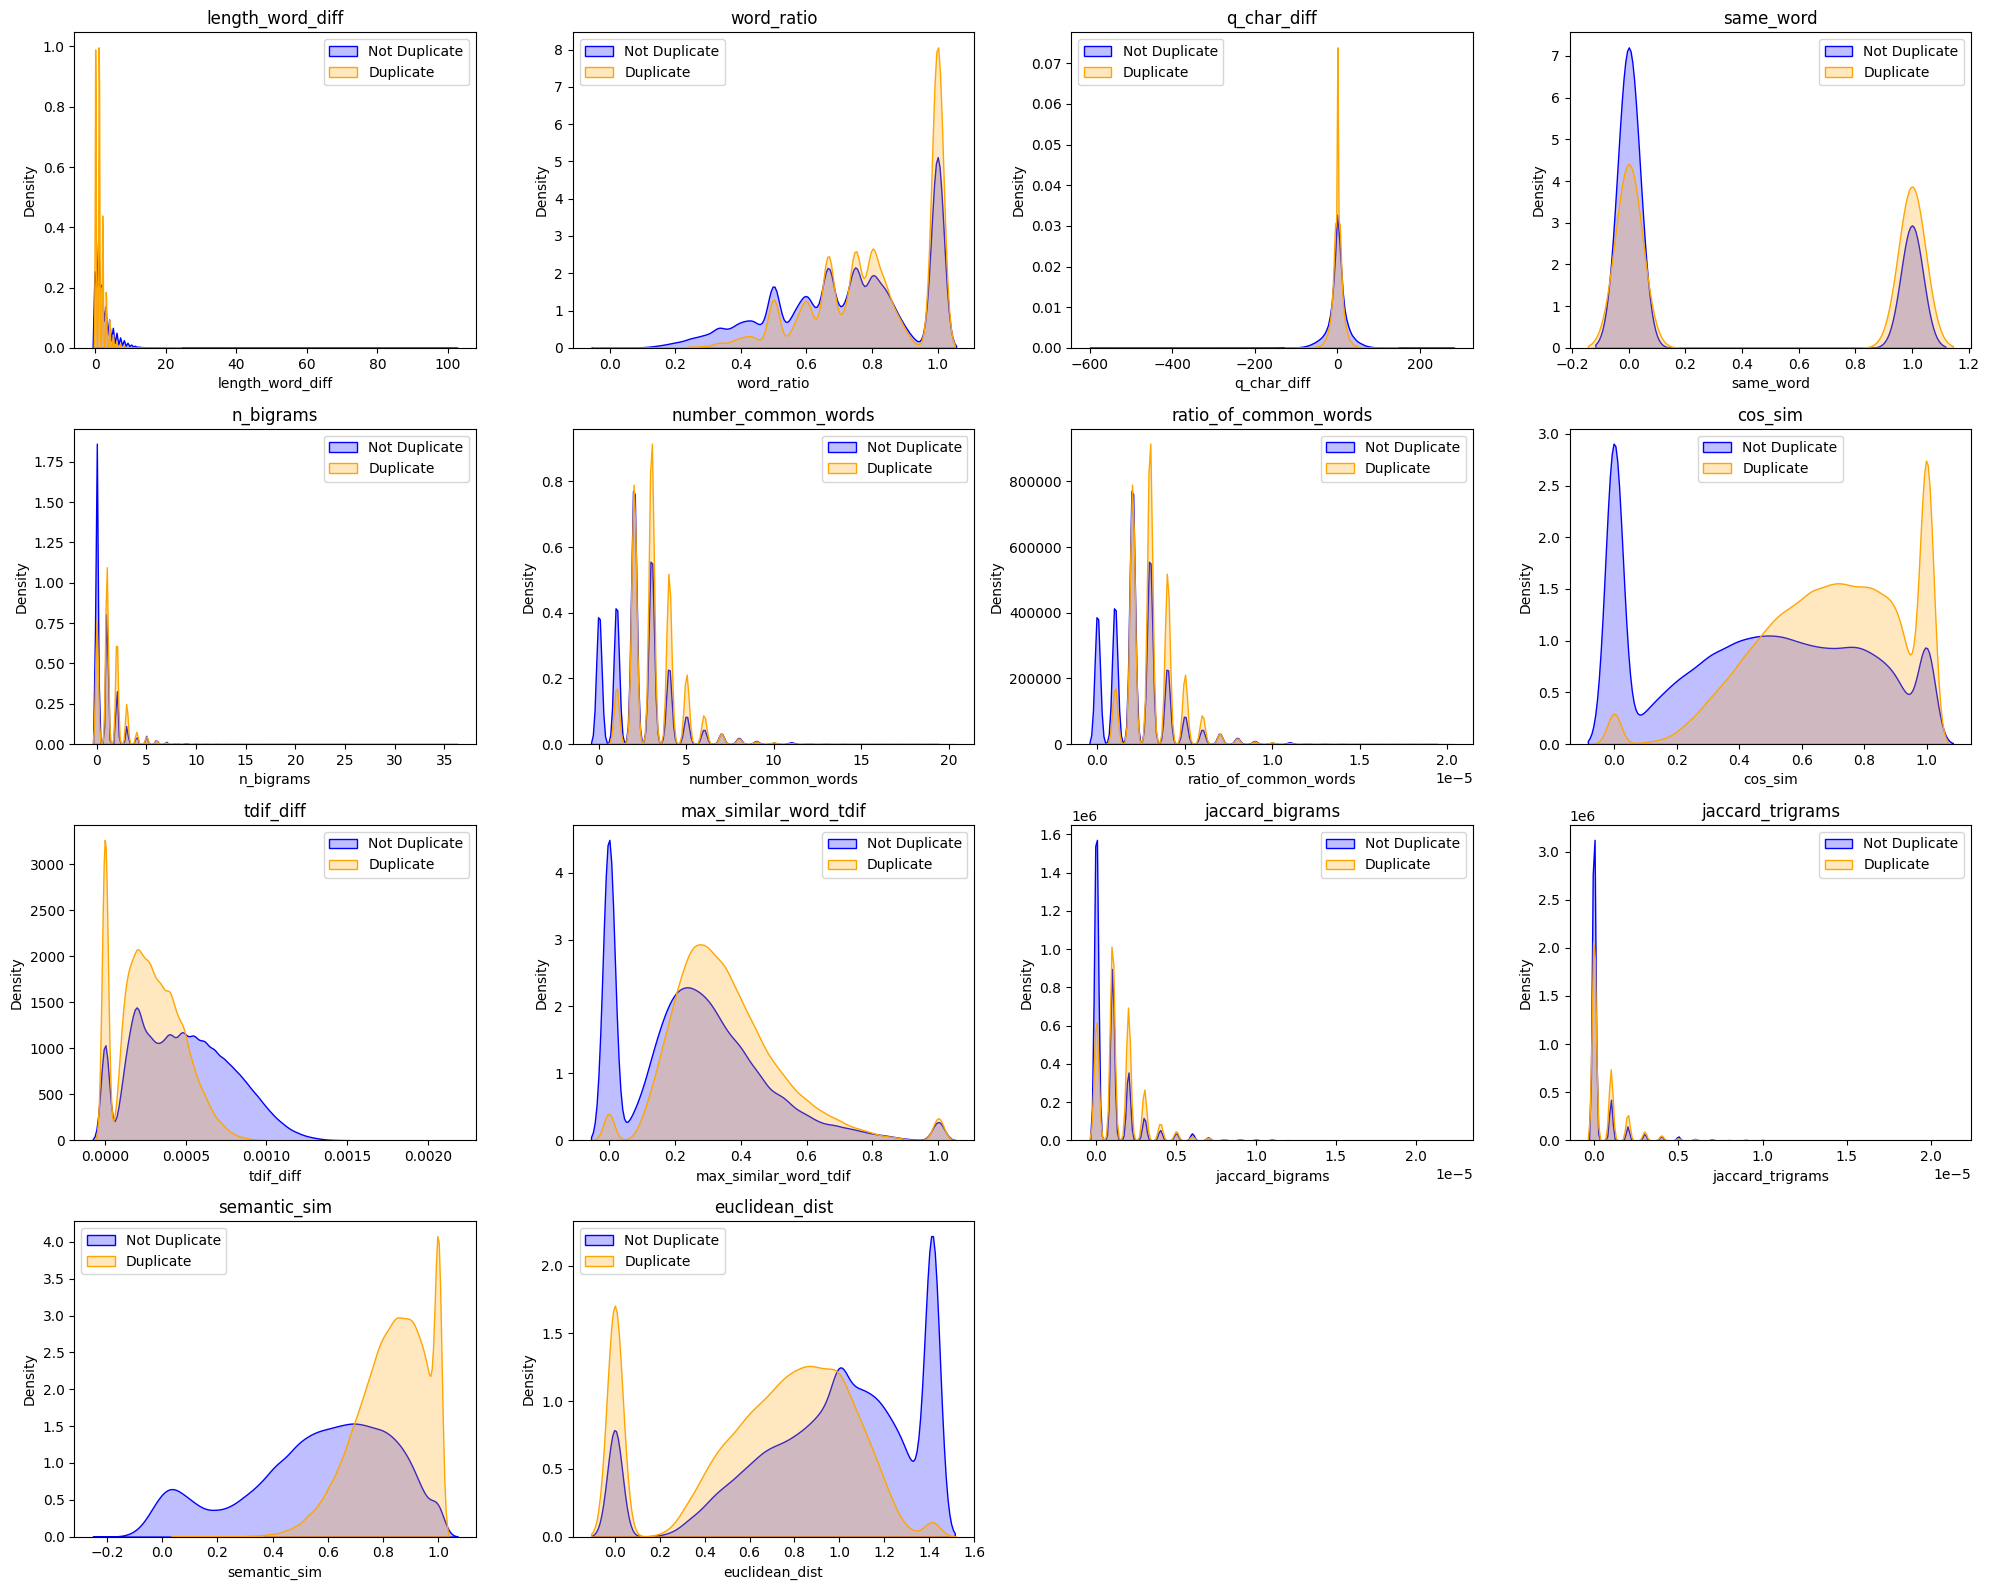

In [21]:
features = [
    'length_word_diff', 'word_ratio', 'q_char_diff', 'same_word',
    'n_bigrams', 'number_common_words', 'ratio_of_common_words',
    'cos_sim', 'tdif_diff', 'max_similar_word_tdif',
    'jaccard_bigrams', 'jaccard_trigrams', 'semantic_sim', 'euclidean_dist'
]

n_cols = 4
n_rows = (len(features) + n_cols - 1) // n_cols
plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for idx, feature in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.kdeplot(data=df[df['is_duplicate'] == 0], x=feature, fill=True, label='Not Duplicate', color='blue', common_norm=False)
    sns.kdeplot(data=df[df['is_duplicate'] == 1], x=feature, fill=True, label='Duplicate', color='orange', common_norm=False)
    plt.title(feature)
    plt.legend()

plt.tight_layout()
plt.show()

1. 'length_word_diff' - duplicated questions usually have smaller difference in the number of words. Not duplicate questions show wider spread.
2. 'word_ratio' - duplicates have higher values (closer to 1), indicating similar length. Non duplicates have wider spread.
3. 'q_char_diff' - duplicated questions have small difference in number of characters compared to non-duplicates. Non duplicates show wider spread in number of characters between questions.
4. 'same_word' - the duplicated questions more frequently start with the same word compared to non-duplicated. Non duplicates mostly start with different word.
5. 'n_bigrams' - duplicates contain slightly more overlapping bigrams. Non duplicates mostly have none common bigrams.
6. 'number_common_words' - duplicates have more common words compared to  non-duplicates.
7. 'ratio_of_common_words' - duplicates tend to have a higher ratio of common words. Non duplicates skew lower.
8. 'cos_sim' - duplicates have peaks near 1. Non-duplicates often show low similiarity. One of the most strongest feature.
9. 'average TD-IF vectors diff' - duplicates are more concentrated at lower values that indicates about high similarity between two vectors. Non-duplicates are more dispersed with larger difference.
10. 'max_similar_word_tdif' - duplicates show mid-to-high similarity. Non-duplicates peaks at zero. Strong feature that shows strong word matches.
11. 'jaccard_bigrams', 'jaccard_trigrams' - both have extremely small differences between classes.
12. 'semantic_sim' - one the most powerful feautures. Duplicates are mostly skewed aroud 1. Non duplicates have lover semantic similarity.
13. 'euclidean_dist' - duplicates are closer together. Non-duplicates show more variation.


In [24]:
corr_matrix = df.corr()

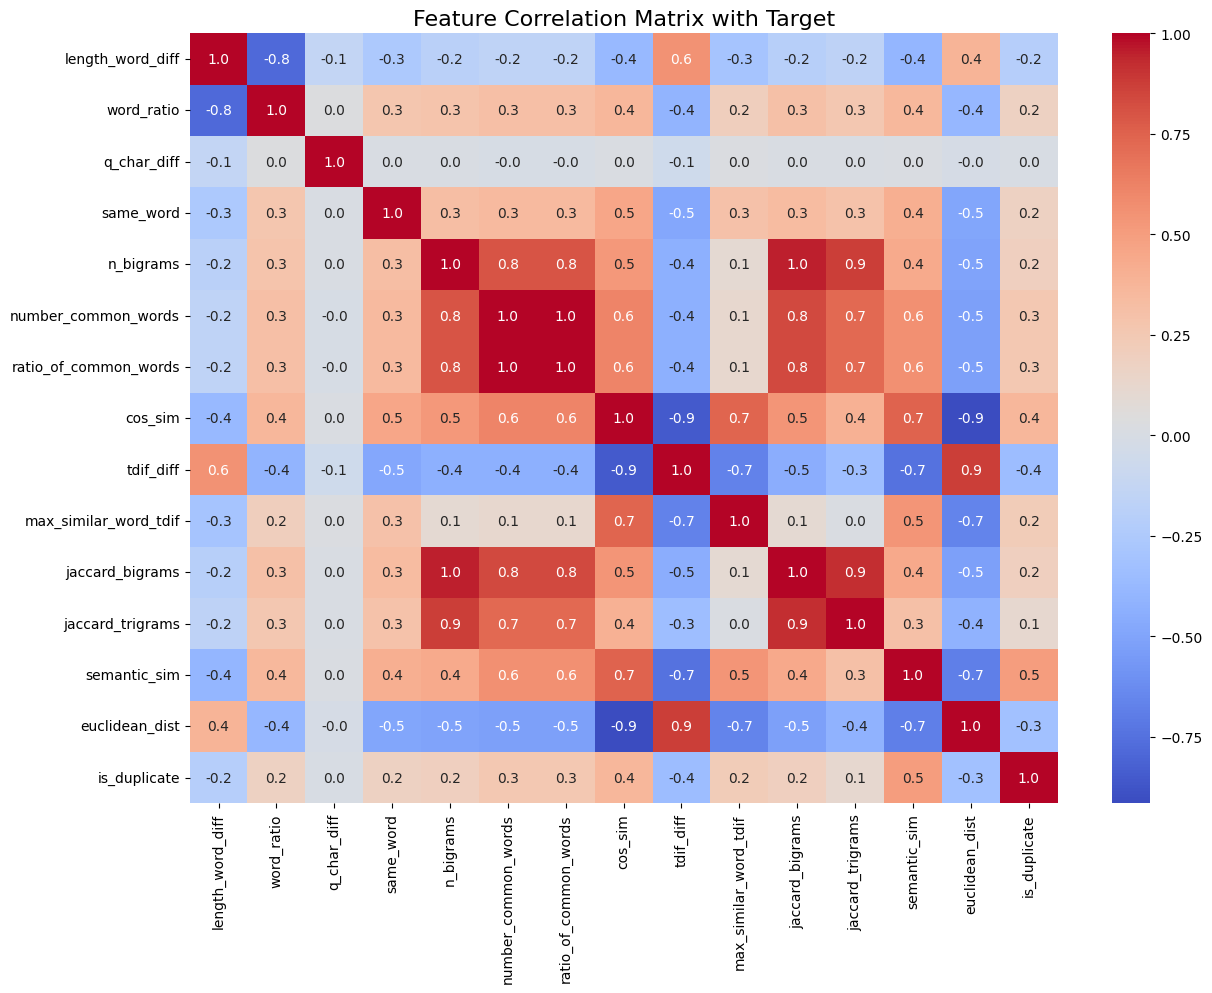

In [28]:
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.1f', cmap='coolwarm')
plt.title("Feature Correlation Matrix with Target", fontsize=16)
plt.show()

'semantic_sim', 'cos_sim', 'tdif_diff', 'number_of_common_words', 'ratio_of_common_words' are the most correlated features with the target column.

###Creating pipeline

In [59]:
pipeline_1 = Pipeline([
    ('textprocess', DataTransformer()),
    ('feature_creation', FeatureCreation()),
    ('model', LogisticRegression(class_weight='balanced', random_state=42))
])

###Model Evaluation

In [60]:
def evaluate_model(pipeline, X_test_data, y_test_data, model):
  """
  Evaluates a trained classification pipeline on test data using common metrics
  """

  y_proba = pipeline.predict_proba(X_test)[:,1]
  y_preds = pipeline.predict(X_test)
  metrics = {
      'model': model,
      'f1_score': f1_score(y_test_data, y_preds),
      'log_loss': log_loss(y_test_data, y_proba)
  }
  return metrics

In [61]:
results=[]

In [ ]:
pipeline_1.fit(X_train,y_train)

results.append(evaluate_model(pipeline=pipeline_1, X_test_data=X_test, y_test_data=y_test, model='log_reg'))

In [63]:
joblib.dump(pipeline_1, 'drive/MyDrive/ML/Final Project Quora/pipeline_logreg_balanced.pkl')

['drive/MyDrive/ML/Final Project Quora/pipeline_logreg_balanced.pkl']

In [64]:
res = pd.DataFrame(results)
res

,model,f1_score,log_loss
0,log_reg,0.699155,0.501661


##Random Forest

In [65]:
pipeline_rf = Pipeline([
    ('textprocess', DataTransformer()),
    ('feature_creation', FeatureCreation()),
    ('model', RandomForestClassifier(
    n_estimators=120,
    class_weight='balanced',
    n_jobs=-1
))
])

In [66]:
pipeline_rf.fit(X_train,y_train)

results.append(evaluate_model(pipeline=pipeline_rf, X_test_data=X_test, y_test_data=y_test, model='random_forest'))

In [72]:
res = pd.DataFrame(results)
res

,model,f1_score,log_loss
0,log_reg,0.699155,0.501661
1,random_forest,0.715320,0.482371


In [68]:
joblib.dump(pipeline_rf, 'drive/MyDrive/ML/Final Project Quora/pipeline_random_forest.pkl')

['drive/MyDrive/ML/Final Project Quora/pipeline_random_forest.pkl']

In [69]:
file_path = 'drive/MyDrive/ML/Final Project Quora/model_results.csv'

if not os.path.exists(file_path):
  res.to_csv(file_path, index=False)
else:
  res.to_csv(file_path, mode='a', index=False, header=False)